In [1]:
%reset -f
import numpy as np
import pandas as pd
import random
import math
import os
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

In [2]:
mat = scipy.io.loadmat('NASAtrain_ICA_part.mat') #reads dataset
#mat = scipy.io.loadmat('NASAtrain_I.mat') #reads dataset for I segments
cellsName = [keys for keys in mat.keys() if not keys.startswith('__')]
numCell = len(cellsName)
print("mat structure:", numCell)
print("Name of cells:", cellsName)

mat structure: 4
Name of cells: ['train1', 'train2', 'train3', 'train4']


# Dataload design

In [3]:
# Extract data from matalab to list in python
Sequences = []
Labels = []
Length_ICA = []
windows = 15

for i in range(numCell):
    mat[cellsName[i]][0][0].dtype.names
    mat[cellsName[i]][0][0]['data'][0][0].shape
    numCycle = len(mat[cellsName[i]][0][0]['data'])
    numCycle

    ICA = [[] for _ in range(numCycle)]
    label = [[] for _ in range(numCycle)]
    length = [[] for _ in range(numCycle)]
    Sequences_temp = [[] for _ in range(numCycle-windows)]
    Labels_temp = [[] for _ in range(numCycle-windows)]

    for j in range(numCycle):
      ICA[j] =  torch.tensor(mat[cellsName[i]][0][0]['data'][j][0]).float() # list contain tensor sequences
      label[j] = torch.tensor(mat[cellsName[i]][0][0]['label'][j][0]).float()
      length[j] = len(mat[cellsName[i]][0][0]['data'][j][0][0])

    for j in range(windows, numCycle):
      Sequences_temp[j - windows] = ICA[j - windows:j]
      #Labels_temp[j - windows] = label[j - windows:j] #collect all labels
      Labels_temp[j - windows] = label[j] # Only labels for final cycle

    Length_ICA.extend(length)
    Sequences.extend(Sequences_temp)
    Labels.extend(Labels_temp)
# The dataset include the packed datas(size = windows) in format of list
# All datas are already the tensor format
print(f"size of ICA curves: {len(Length_ICA)}")
print(f"size of DataSequences(s): {len(Sequences)}")
print(f"Typical element of Dataset: {len(Sequences[1])}")
for i in range(len(Sequences[1])):
  print(Sequences[0][i].shape)

print(Labels[1])

size of ICA curves: 636
size of DataSequences(s): 576
Typical element of Dataset: 15
torch.Size([3, 55])
torch.Size([3, 57])
torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 56])
torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 60])
tensor(0.9710)


In [4]:
Sequences[0][i][2]

tensor([ 221.2068,  570.8605,  895.0165, 1123.0601, 1309.8953, 1492.1598,
        1650.4678, 1782.8020, 1912.1311, 2031.6567, 2129.3669, 2222.8301,
        2306.3638, 2383.7903, 2482.8816, 2595.6233, 2701.7517, 2788.4863,
        2843.0508, 2861.5823, 2896.3113, 2932.9468, 2930.4512, 2895.4392,
        2842.2422, 2828.8110, 2836.5410, 2865.0112, 2892.6895, 2957.5356,
        3035.6055, 3070.0691, 3127.2673, 3218.6035, 3276.0825, 3312.8311,
        3403.6404, 3475.6936, 3513.7468, 3568.9919, 3604.4565, 3610.1230,
        3607.4746, 3626.5474, 3665.3650, 3704.9353, 3748.0488, 3767.9600,
        3831.1030, 3905.0044, 3965.9045, 4035.7036, 4085.1494, 4140.2612,
        4242.4438, 4320.6621, 4398.1504, 4484.5649, 4294.3491, 3179.2263])

torch.Size([3, 57])
torch.Size([3, 58])
torch.Size([3, 58])
torch.Size([3, 60])
torch.Size([3, 58])
torch.Size([3, 57])
torch.Size([3, 55])
torch.Size([3, 56])
torch.Size([3, 56])
torch.Size([3, 56])
torch.Size([3, 55])
torch.Size([3, 54])
torch.Size([3, 55])
torch.Size([3, 54])
torch.Size([3, 55])


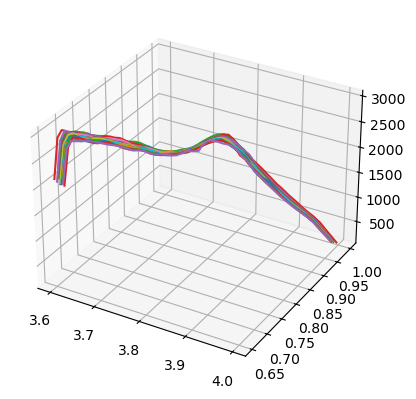

In [5]:
ax = plt.figure().add_subplot(projection='3d')
n = 100
for i in range(len(Sequences[1])):
  print(Sequences[n][i].shape)
  ax.plot(np.array(Sequences[n][i][0]), np.array(Sequences[n][i][1]), np.array(Sequences[n][i][2]), label='ICA')  

In [6]:
# Pack to dataset useing customised class
class MultiSequenceDataset(Dataset):
  # Here each returen will be a list of sequences and corresponding label
  # Demo like: Sequences, Labels = dataset[i]
    def __init__(self, data_points, targets):
        self.data_points = data_points
        self.targets = targets

    def __len__(self):
        return len(self.data_points)

    def __getitem__(self, idx):
        return self.data_points[idx], self.targets[idx]

    def total_sequences(self):
        return sum(len(sequences) for sequences in self.data_points)

dataset = MultiSequenceDataset(Sequences, Labels)
# Get the number of top-level data points in the dataset
print("Number of top-level data points in the dataset:", len(dataset))

# Get the total number of sequences in the dataset
print("Total number of sequences in the dataset:", dataset.total_sequences())

def collate_fn(batch):
    data_points, targets = zip(*batch)
    return data_points, torch.tensor(targets)

dataloader = DataLoader(dataset, batch_size=128, collate_fn=collate_fn)

def rmse_loss(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

Number of top-level data points in the dataset: 576
Total number of sequences in the dataset: 8640


In [7]:
# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=512, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=512, collate_fn=collate_fn)

print(f"batch num of train_loader: {len(train_loader)} \nbatch num of test_loader: {len(test_loader)}")
print("--------------------------------------------------")
X_batch, T_batch= next(iter(test_loader))
print("Example size of dataloader display:")
for i in range(len(X_batch)):
    print(f"{i+1}: \t{len(X_batch[i])} \t{X_batch[i][1].shape} \t{T_batch[i]}" )

batch num of train_loader: 1 
batch num of test_loader: 1
--------------------------------------------------
Example size of dataloader display:
1: 	15 	torch.Size([3, 47]) 	0.6477811932563782
2: 	15 	torch.Size([3, 46]) 	0.6607271432876587
3: 	15 	torch.Size([3, 58]) 	0.9834644198417664
4: 	15 	torch.Size([3, 58]) 	0.8754359483718872
5: 	15 	torch.Size([3, 59]) 	0.9789876937866211
6: 	15 	torch.Size([3, 71]) 	0.8898303508758545
7: 	15 	torch.Size([3, 55]) 	0.7559671401977539
8: 	15 	torch.Size([3, 59]) 	0.9029194116592407
9: 	15 	torch.Size([3, 73]) 	0.9457787871360779
10: 	15 	torch.Size([3, 71]) 	0.89793860912323
11: 	15 	torch.Size([3, 56]) 	0.763130784034729
12: 	15 	torch.Size([3, 56]) 	0.7694886922836304
13: 	15 	torch.Size([3, 52]) 	0.7271508574485779
14: 	15 	torch.Size([3, 47]) 	0.6300842761993408
15: 	15 	torch.Size([3, 56]) 	0.7572755217552185
16: 	15 	torch.Size([3, 54]) 	0.7409896850585938
17: 	15 	torch.Size([3, 71]) 	0.9376848936080933
18: 	15 	torch.Size([3, 54]) 	0.74

# Model define

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class CNN_LSTM_position(nn.Module):
    def __init__(self, num_channels, num_heads, num_hidden_units):
        super(CNN_LSTM_position, self).__init__()
        # Single CNN layer
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.positional_encoding = PositionalEncoding(32)
        self.self_attention = nn.MultiheadAttention(32, num_heads)
        self.lstm = nn.LSTM(32, num_hidden_units, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(num_hidden_units, 16)
        #self.fc2 = nn.Linear(9, 1)
    def forward(self, x):
        # Apply the single CNN layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = x.transpose(1, 2)  # Convert to (batch, seq_length, channels)

        # Apply self-attention
        x = x.transpose(0, 1)  # Convert to (seq_length, batch, channels)      
        x, attn_weights = self.self_attention(x, x, x)
        x = x.transpose(0, 1)  # Convert to (batch, seq_length, channels)

        # Add positional encoding
        x = self.positional_encoding(x)              
        # Select top features based on attention weights
        attn_weights = attn_weights.mean(dim=1)  # Average over heads
        topk_indices = attn_weights.topk(16, dim=1, largest=True).indices  # Top 32 features
        batch_indices = torch.arange(x.size(0)).unsqueeze(-1).to(x.device)
        x = x[batch_indices, topk_indices]      
        
        x = self.relu(x)
        x = x.reshape(x.size(0), -1, 32)  # (batch, new_seq_length, channels)
        
        # Directly pass the sequence to LSTM
        x, (hn, cn) = self.lstm(x)
        hn = self.dropout(hn)
        x = self.fc1(hn[-1])
        x = self.relu(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        return x

class LSTMMultiCyclesRegressor(nn.Module):
    def __init__(self, num_channels, num_heads, num_hidden_units):
        super(LSTMMultiCyclesRegressor, self).__init__()
        # HF extraction layer via CNN-Att-LSTM
        self.HFextract = CNN_LSTM_position(num_channels, num_heads, num_hidden_units)
        
        # LSTM regression
        self.lstm = nn.LSTM(
            input_size=16,  # Assuming univariate input to the LSTM (adjust if needed)
            hidden_size=num_hidden_units,
            num_layers=3,
            batch_first=True,
            bidirectional=True  # Set to bidirectional LSTM
        )

        self.dropout = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(num_hidden_units * 2, 9)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(9, 1)

    def forward(self, x):
        batch_size = len(x)
        processed_sequences = []

        for sequences in x:
            HFs = []
            min_length = min(tensor.shape[1] for tensor in sequences)
            trimmed_tensors = [tensor[:, :min_length] for tensor in sequences]         
            sequences = torch.stack(trimmed_tensors)           
            HFs = self.HFextract(sequences)
            #print(HFs.shape)
            processed_sequences.append(HFs)        

        processed_sequences = torch.stack(processed_sequences)  # Convert to [batch_size, num_sequences, HF_features]
        
        # Regression through LSTM
        x, (hn, cn) = self.lstm(processed_sequences)
        hn_forward = hn[-2]
        hn_backward = hn[-1]
        hn_combined = torch.cat((hn_forward, hn_backward), dim=1)  # Concatenate along hidden unit dimension
        hn_combined = self.dropout(hn_combined)
        # Fully connected layers
        x = self.fc3(hn_combined)
        x = self.relu(x)
        output = self.fc4(x)
        return output
# Example usage

model = LSTMMultiCyclesRegressor(num_channels=3, num_heads=4, num_hidden_units=64)

In [9]:
print(model)

LSTMMultiCyclesRegressor(
  (HFextract): CNN_LSTM_position(
    (conv1): Conv1d(3, 32, kernel_size=(5,), stride=(1,), padding=same)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (positional_encoding): PositionalEncoding()
    (self_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (lstm): LSTM(32, 64, batch_first=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=64, out_features=16, bias=True)
  )
  (lstm): LSTM(16, 64, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=9, bias=True)
  (relu): ReLU()
  (fc4): Linear(in_features=9, out_features=1, bias=True)
)


In [10]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Training parameters
num_epochs = 5000
learning_rate = 0.0001

# Optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)


# RMSE Loss Function
def rmse_loss(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

# Lists to store losses
train_losses = []
test_losses = []

# Variable to store the best model and the lowest loss
best_model_state = None
lowest_train_loss = float('inf')

# Training and testing loop with inspection
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = [[seq.to(device) for seq in sequence] for sequence in inputs]
        #print(f"Batch {batch_idx} - Input shape: {len(inputs)}, {len(inputs[0])}, {inputs[0][0].shape}")
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = rmse_loss(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    

    # Save the best model based on training loss
    if train_loss < lowest_train_loss:
        lowest_train_loss = train_loss
        best_model_state = model.state_dict()

    # Test the model after each epoch
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = [[seq.to(device) for seq in sequence] for sequence in inputs]
            targets = targets.to(device)
            outputs = model(inputs)
            loss = rmse_loss(outputs.squeeze(), targets)
            test_loss += loss.item()
    
    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    # Loss display
    if (epoch+1)%20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}")

    # Adjust the learning rate based on the validation loss
    #scheduler.step(test_loss)

# Save the best model to a file
torch.save(best_model_state, 'best_model.pth')

# Plot the losses using RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training RMSE')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training and Test RMSE')
plt.show()


Using device: cuda
Epoch [20/5000], Training Loss: 0.7014
Epoch [20/5000], Test Loss: 0.7008
Epoch [40/5000], Training Loss: 0.6169
Epoch [40/5000], Test Loss: 0.6102
Epoch [60/5000], Training Loss: 0.4158
Epoch [60/5000], Test Loss: 0.3955
Epoch [80/5000], Training Loss: 0.1585
Epoch [80/5000], Test Loss: 0.1344
Epoch [100/5000], Training Loss: 0.1208
Epoch [100/5000], Test Loss: 0.1026
Epoch [120/5000], Training Loss: 0.1207
Epoch [120/5000], Test Loss: 0.1042
Epoch [140/5000], Training Loss: 0.1241
Epoch [140/5000], Test Loss: 0.1027
Epoch [160/5000], Training Loss: 0.1171
Epoch [160/5000], Test Loss: 0.1022
Epoch [180/5000], Training Loss: 0.1139
Epoch [180/5000], Test Loss: 0.1021
Epoch [200/5000], Training Loss: 0.1089
Epoch [200/5000], Test Loss: 0.1041
Epoch [220/5000], Training Loss: 0.1021
Epoch [220/5000], Test Loss: 0.1085
Epoch [240/5000], Training Loss: 0.1015
Epoch [240/5000], Test Loss: 0.1149
Epoch [260/5000], Training Loss: 0.0968
Epoch [260/5000], Test Loss: 0.1200
E

KeyboardInterrupt: 